In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

In [2]:
df_con = pd.read_table('/Users/Jem/Desktop/Rong360data/data/consumption_recode.txt', sep = ',')
df_user = pd.read_table('/Users/Jem/Desktop/Rong360data/data/user_info.txt', sep = ',')
df_training = pd.read_table('/Users/Jem/Desktop/Rong360data/data/train.txt', sep = ',')
df_test = pd.read_table('/Users/Jem/Desktop/Rong360data/data/test.txt', sep = ',')

In [3]:
df_re1 = pd.read_table('/Users/Jem/Desktop/Rong360data/data/relation1.txt', sep = ',')
df_re2 = pd.read_table('/Users/Jem/Desktop/Rong360data/data/relation2.txt', sep = ',')

# EDA

In [102]:
df_re2_1 = df_re2[df_re2['relation2_type'] == 1]
df_re2_2 = df_re2[df_re2['relation2_type'] == 2]
df_re2_3 = df_re2[df_re2['relation2_type'] == 3]

In [46]:
weight_1 = df_re2_1['relation2_weight'].values.tolist()
time_1 = df_re2_1['time'].values.tolist()
weight_2 = df_re2_2['relation2_weight'].values.tolist()
time_2 = df_re2_2['time'].values.tolist()
weight_3 = df_re2_3['relation2_weight'].values.tolist()
time_3 = df_re2_3['time'].values.tolist()

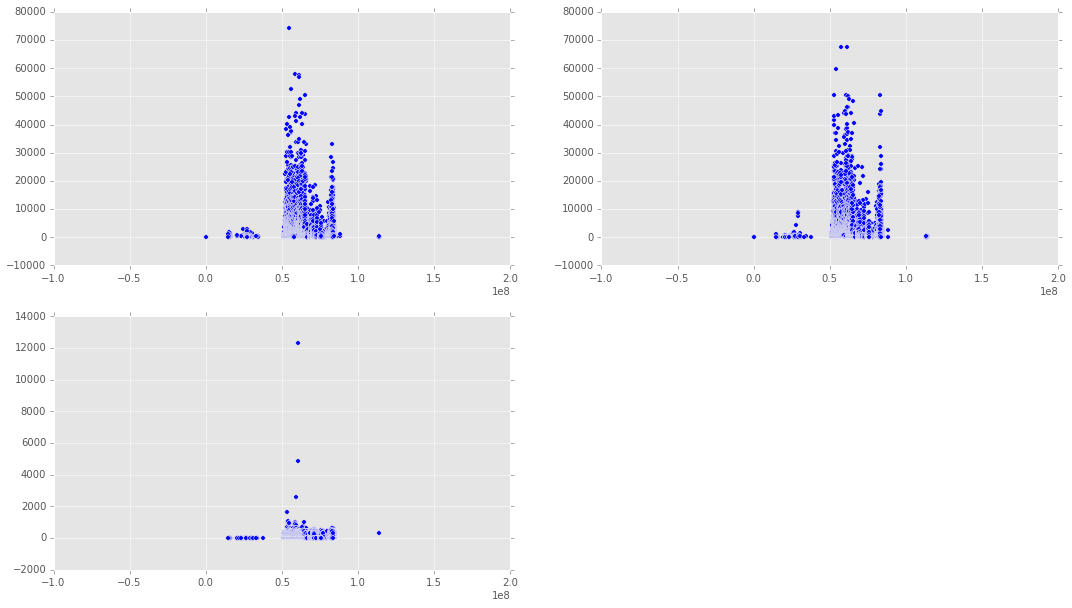

In [49]:
fig = plt.figure(figsize=(18,10))

ax1 = fig.add_subplot(2, 2, 1)
ax1.scatter(time_1, weight_1)
ax1.set_xlim([-10**8, 2*10**8])

ax2 = fig.add_subplot(2, 2, 2)
ax2.scatter(time_2, weight_2)
ax2.set_xlim([-10**8, 2*10**8])

ax3 = fig.add_subplot(2, 2, 3)
ax3.scatter(time_3, weight_3)
ax3.set_xlim([-10**8, 2*10**8])

fig.show()

In [127]:
drop_list = ['current_convert_jifen', 'current_award_jifen', 'current_repay_amt_usd', 'current_min_repay_amt_usd', 
             'repay_stat', 'curr', 'credit_lmt_amt_usd', 'pre_borrow_cash_amt_usd', 'card_type', 'avlb_bal', 
             'avlb_bal_usd', 'current_adj_jifen','prior_period_jifen_bal', 'circle_interest', 'adj_amt', 'bill_id']

In [227]:
df_con = df_con.drop(drop_list, axis = 1)

In [229]:
df_con['prior_period_bill_amt'].value_counts()

print df_con['prior_period_bill_amt'].value_counts()/len(df_con)
print len(np.unique( df_con['prior_period_bill_amt'].values.tolist()))

In [232]:
len(df_con)

677540

In [231]:
len(np.unique(df_con['user_id'].values.tolist()))

23066

# Process the original data

In [267]:
# process df_con: impute the mean value by dropping 0, add num_cheat and total_num

from __future__ import division

dic = {'user_id':[], 'prior_period_bill_amt':[], 'prior_period_repay_amt':[], 'credit_lmt_amt':[], 'curt_jifen':[],
      'current_bill_bal':[], 'current_bill_min_repay_amt':[], 'cost_cnt':[], 'current_bill_amt':[],
      'nadd_jifen':[], 'pre_borrow_cash_amt':[], 'num_cheat':[], 'total_num':[]}

for user in np.unique(df_con['user_id']):
    tmp = df_con[df_con['user_id'] == user]
    col = tmp.columns.tolist()
    col.remove('user_id')
    col.remove('is_cheat_bill')
    
    for feature in col:
        tmp[feature] = tmp[feature].replace(to_replace = 0, value = np.nan).dropna()
        mean = tmp[feature].mean()
        dic[feature].append(mean)
    dic['num_cheat'].append(tmp['is_cheat_bill'].values.sum())
    dic['total_num'].append(len(tmp))
    dic['user_id'].append(user)
    
    df_con = df_con.drop(tmp.index)
    
df_con_ = pd.DataFrame(dic)
df_con_.to_csv('/Users/Jem/Desktop/df_con_')

In [550]:
# process df_user: transform NONE and NaN to 0 then use the row which has the maximum tm_encode, finally replace
# 0 with the maximum value in the feature for a specific user 

from math import isnan

df_user = df_user.drop('max_month_repay', axis = 1)
df_user_ = pd.DataFrame()
j = 0
for items in np.unique(df_user['user_id']):
    tmp = df_user[df_user['user_id'] == items]
    tmp = tmp.fillna(0)
    tmp.replace(to_replace = 'NONE', value = 0, inplace = True)

    index_max =  tmp['tm_encode'].values.tolist().index(max(tmp['tm_encode'].values))
    new = pd.DataFrame(tmp.iloc[index_max][:]).T
    
    columns = tmp.columns.tolist()
    columns.remove('user_id')
    
    for feature in columns:
        new[feature].replace(to_replace = 0, value = int(max(tmp[feature].values.tolist())), inplace = True)
    df_user_ = pd.concat([df_user_, new])
    j += 1
    if j % 5000 == 0:
        print j

df_user_.to_csv('/Users/Jem/Desktop/df_user_.csv')

In [496]:
# process df_re1: calculate the total number of relations for user1_id

set1 = set(df_re1['user1_id'].values.tolist())
set2 = set(df_re1['user2_id'].values.tolist())

df_re1_ = pd.DataFrame()
dic = {'user_id':[], 'num_rel':[]}
j = 0

for user in set1:
    tmp = df_re1[df_re1['user1_id'] == user]
    num = len(tmp)
    dic['user_id'].append(user)
    dic['num_rel'].append(num)
#     s = pd.Series([user, num], index = ['user1_id', 'number'])
#     new = pd.DataFrame(s).T
#     df_re1_ = pd.concat([df_re1_, new])
    j = j + 1
    if j % 5000 == 0:
        print j
df_re1_ = pd.DataFrame(dic, columns = ['user_id', 'num_rel'])
df_re1_.to_csv('/Users/Jem/Desktop/df_re_1.csv')

In [497]:
# process df_re2: calculate the number of relations for type 1, 2, 3. The weight for type 1, 2, 3.

from __future__ import division

df_re2 = df_re2.drop(['time', 'user2_id'], axis = 1).drop_duplicates()
df_re2_ = pd.DataFrame()
set_1 = set(df_re2['user1_id'].values.tolist())
dic = {'user_id':[], 'num_1':[], 'weight_1':[], 'num_2':[], 'weight_2':[], 'num_3':[], 'weight_3':[]}
j = 0

for user in set_1:
    d = df_re2[df_re2['user1_id'] == user]
    relation = d['relation2_type'].values.tolist()
    grouped = d.groupby('relation2_type')
    weight = grouped.aggregate(np.sum)['relation2_weight']

    try:
        weight_1 = weight[1]/relation.count(1)
    except:
        weight_1 = 0
    try:
        weight_2 = weight[2]/relation.count(2)
    except:
        weight_2 = 0
    try:
        weight_3 = weight[3]/relation.count(3)
    except:
        weight_3 = 0
    
    dic['user_id'].append(user)
    dic['num_1'].append(relation.count(1))
    dic['weight_1'].append(weight_1)
    dic['num_2'].append(relation.count(2))
    dic['weight_2'].append(weight_2)
    dic['num_3'].append(relation.count(3))
    dic['weight_3'].append(weight_3)
    
    df_re2 = df_re2.drop(d.index)
    
    j += 1
    if j % 2000 == 0:
        print j
    
df_re2_ = pd.DataFrame(dic, columns = ['user_id', 'num_1', 'num_2', 'num_3', 'weight_1', 'weight_2', 'weight_3'])
df_re2_.to_csv('/Users/Jem/Desktop/df_re_2_.csv')

# EDA on Merged data

In [2]:
df_training = pd.read_table('/Users/Jem/Desktop/Rong360data/data/train.txt', sep = ',')
df_test = pd.read_table('/Users/Jem/Desktop/Rong360data/data/test.txt', sep = ',')

df_re1_ = pd.read_csv('/Users/Jem/Desktop/Rong360data/df_re_1.csv')
df_re2_ = pd.read_csv('/Users/Jem/Desktop/Rong360data/df_re_2.csv')
df_user_ = pd.read_csv('/Users/Jem/Desktop/Rong360data/user_clean.csv')
df_con_ = pd.read_csv('/Users/Jem/Desktop/Rong360data/df_con_.csv')

In [3]:
# data_re = pd.merge(df_re1_, df_re2_, on = 'user_id', how = 'outer')
data_user = pd.merge(df_user_, df_con_, on = 'user_id', how = 'outer')
data_tmp = pd.merge(df_re1_, data_user, on = 'user_id', how = 'outer')
data_training = pd.merge(df_training, data_tmp, on = 'user_id', how = 'left')
# data_training_rong = pd.merge(data_training, df_rong, on = 'user_id', how = 'left')
data_test = pd.merge(df_test, data_tmp, on = 'user_id', how = 'left')

In [4]:
print len(np.unique(data_tmp['user_id'].values.tolist())), len(data_tmp)

38261 38261


# Missing values in df_con_

In [308]:
# There are 21384 users in data_training whose id = 1, 13286 of them also appear in df_con_

df1 = data_training[data_training['product_id'] == 1]
user1 = np.unique(df1['user_id']).tolist()
a = np.unique(df_con_['user_id']).tolist()

a_user1 = list((set(a).union(set(user1)))^(set(a)^set(user1)))
print len(a_user1), len(df1)

13286 21384


In [307]:
# There are 4616 users in data_training whose id = 2, 2661 of them also appear in df_con_

df2 = data_training[data_training['product_id'] == 2]
user2 = np.unique(df2['user_id']).tolist()
a = np.unique(df_con_['user_id']).tolist()

a_user2 = list((set(a).union(set(user2)))^(set(a)^set(user2)))
print len(a_user2), len(df2)

2661 4616


In [46]:
# missing value brought out by df_con_: data_training contains 10053 users that not appears in df_con_
# so 10053 missing values in data_training has nothing to do with the missing values in df_con_
# so we know that df_con_ contributes little to missing values in data_training

df_con_.isnull().sum(axis=0)
user_con = np.unique(df_con_['user_id'].values.tolist())
a = np.unique(data_training['user_id'].values.tolist())
lis = list((set(a).union(set(user_con)))^(set(a)^set(user_con)))

print str(len(lis)) + ' ' + 'users appear both in data_training and df_con_'
print str(len(a)) + ' ' + 'users appear in data_training' 
print str(len(df_con_)) + ' ' + 'users appear in df_con_'
print str(len(a) - len(lis)) + ' ' + 'users appear in data_training but not in df_con_, so this part of missing has nothing to do with df_con_' 

15947 users appear both in data_training and df_con_
26000 users appear in data_training
23066 users appear in df_con_
10053 users appear in data_training but not in df_con_, so this part of missing has nothing to do with df_con_


In [618]:
data_training.isnull().sum(axis = 0)

user_id                           0
lable                             0
num_rel                        3122
num_1                         18524
num_2                         18524
num_3                         18524
weight_1                      18524
weight_2                      18524
weight_3                      18524
age                               0
sex                               0
expect_quota                      0
max_month_repay               21384
occupation                        0
education                         0
marital_status                    0
live_info                         0
local_hk                       4616
money_function                 4616
company_type                      1
salary                            1
school_type                    4616
flow                           4616
gross_profit                   4616
business_type                  4616
business_year                  4617
personnel_num                  4616
pay_type                    

In [620]:
df_con_.isnull().sum(axis = 0)

cost_cnt                      6682
credit_lmt_amt                1547
current_bill_amt              3199
current_bill_bal               127
current_bill_min_repay_amt     309
curt_jifen                    2051
nadd_jifen                    6559
num_cheat                        0
pre_borrow_cash_amt           5118
prior_period_bill_amt         2653
prior_period_repay_amt        2468
total_num                        0
user_id                          0
dtype: int64

the number of missing appears in data_training to the number of total missing in df_con_

In [27]:
from __future__ import division

print 'cost_cnt' + '  ' + str((14466-10053)/6682)
print 'credit_lmt_amt' + '  ' + str((11103-10053)/1547)
print 'current_bill_amt' + '  ' + str((12220-10053)/3199)
print 'current_bill_bal' + '  ' + str((10143-10053)/127)
print 'current_bill_min_repay_amt' + '  ' + str((10280-10053)/309)
print 'curt_jifen' + '  ' + str((11493-10053)/2051)
print 'nadd_jifen' + '  ' + str((14577-10053)/6559)
print 'pre_borrow_cash_amt' + '  ' + str((13560-10053)/5118)
print 'prior_period_bill_amt' + '  ' + str((11825-10053)/2653)
print 'prior_period_repay_amt' + '  ' + str((11673-10053)/2468)

cost_cnt  0.66043100868
credit_lmt_amt  0.678733031674
current_bill_amt  0.677399187246
current_bill_bal  0.708661417323
current_bill_min_repay_amt  0.734627831715
curt_jifen  0.702096538274
nadd_jifen  0.689739289526
pre_borrow_cash_amt  0.685228604924
prior_period_bill_amt  0.667923105918
prior_period_repay_amt  0.656401944895


Except for the 10053 users appear in data_training but not in df_con_, df_con_ contributes a lot to the missing values. On the other hand, more than 50% users in data_training appears in df_con_. So there is a need to impute the missing value in df_con_.

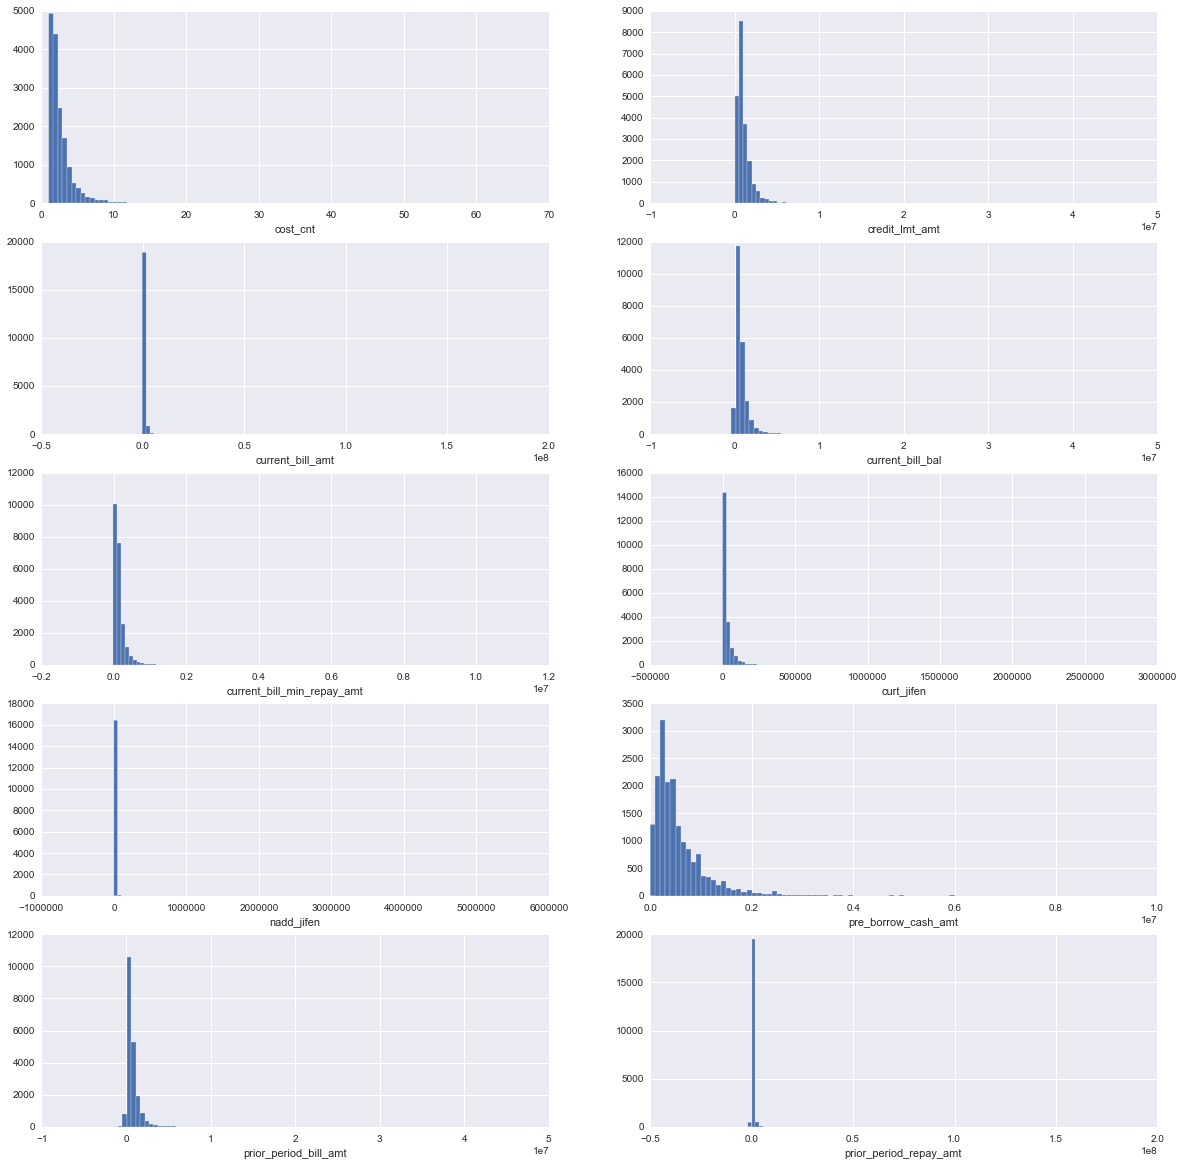

In [136]:
fig = plt.figure(figsize = (20,20))
i = 1
col = df_con_.columns.tolist()
col.remove('num_cheat')
col.remove('total_num')
col.remove('user_id')
for feature in col:
    value = df_con_[feature].dropna().values.tolist()
    ax = fig.add_subplot(5, 2, i)
    ax.hist(value,bins = 100)
    ax.set_xlabel(feature)
    fig.show()
    i += 1
    

Conclusion: There is no obvious pattern in these features.

Check whether there are some differences between is_cheat_bill = 0, 1

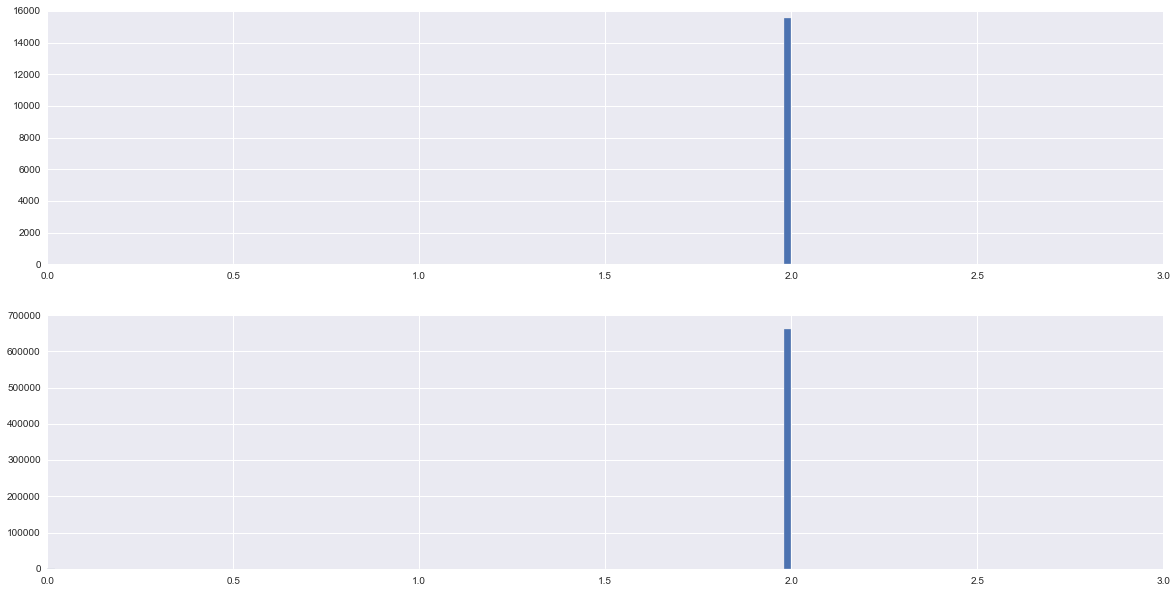

In [134]:
df = df_con[df_con['is_cheat_bill'] == 1]
values1 = df['card_type'].values.tolist()
fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(2,1,1)
ax1.hist(values1, bins = 100)
ax1.set_xlim([0, 3])

df = df_con[df_con['is_cheat_bill'] == 0]
values2 = df['card_type'].values.tolist()
ax2 = fig.add_subplot(2,1,2)
ax2.hist(values2, bins = 100)
ax2.set_xlim([0, 3])
plt.show()

Conclusion: No. It is reasonable to take the average values.

Maybe we can fix the missing value? By grouping users according to the different sets of features.

In [5]:
from __future__ import division 
# product_id = 2

df_con_ = pd.read_csv('/Users/Jem/Desktop/Rong360data/df_con_.csv')

col = ['user_id', 'product_id']
df_pro = data_training[col]
df2 = df_pro[df_pro['product_id'] == 2]
df_con_2 = df2.merge(df_con_, on = 'user_id', how = 'inner')
df_con_2 = df_con_2.drop(['product_id'], axis = 1)

# df_con_2['credit_lmt_amt_weight'] = 0.13
# df_con_2['current_bill_amt_weight'] = 0.148
# df_con_2['current_bill_bal_weight'] = 0.146
# df_con_2['current_bill_min_repay_amt_weight'] = 0.135
# df_con_2['pre_borrow_cash_amt_weight'] = 0.149
# df_con_2['prior_period_bill_amt_weight'] = 0.148
# df_con_2['prior_period_repay_amt_weight'] = 0.144

for feature in df_con_2.columns:
    df_con_2['not_null_' + feature] = df_con_2[feature].isnull().map(lambda x: 0 if x == True else 1)
    df_con_2[feature] = df_con_2[feature].fillna(0)

df_con_2['denominator'] = (0.13*df_con_2['not_null_credit_lmt_amt'] + 0.148*df_con_2['not_null_current_bill_amt'] +
                        0.146*df_con_2['not_null_current_bill_bal'] + 0.135*df_con_2['not_null_current_bill_min_repay_amt'] +
                        0.149*df_con_2['not_null_pre_borrow_cash_amt'] + 0.148*df_con_2['not_null_prior_period_bill_amt'] +
                        0.144*df_con_2['not_null_prior_period_repay_amt'])

df_con_2['numerator'] = (0.13*df_con_2['credit_lmt_amt'] + 0.148*df_con_2['current_bill_amt'] +
                        0.146*df_con_2['current_bill_bal'] + 0.135*df_con_2['current_bill_min_repay_amt'] +
                        0.149*df_con_2['pre_borrow_cash_amt'] + 0.148*df_con_2['prior_period_bill_amt'] +
                        0.144*df_con_2['prior_period_repay_amt'])

df_con_2 = df_con_2[df_con_2['denominator'] != 0]
df_con_2['group_score'] = df_con_2['numerator'] / df_con_2['denominator']

df_con_2['user_score'] = (0.166*df_con_2['group_score'] + 0.166*df_con_2['cost_cnt'] + 0.166*df_con_2['curt_jifen'] +
                         0.166*df_con_2['nadd_jifen'] + 0.166*df_con_2['num_cheat'] + 0.166*df_con_2['total_num']) / (
                         0.166 + 0.166*df_con_2['not_null_cost_cnt'] + 0.166*df_con_2['not_null_curt_jifen'] +
                         0.166*df_con_2['not_null_nadd_jifen'] + 0.166*df_con_2['not_null_num_cheat'] +
                         0.166*df_con_2['not_null_total_num'])

drop_list = ['not_null_credit_lmt_amt', 'not_null_current_bill_amt',
            'not_null_current_bill_bal', 'not_null_current_bill_min_repay_amt', 'not_null_pre_borrow_cash_amt',
            'not_null_prior_period_bill_amt', 'not_null_prior_period_repay_amt', 'not_null_cost_cnt',
            'not_null_curt_jifen', 'not_null_nadd_jifen', 'not_null_num_cheat', 'not_null_total_num',
            'not_null_user_id', 'denominator', 'numerator', 'group_score', 'index']

df_con_2 = df_con_2.reset_index()
df_con_2 = df_con_2.drop(drop_list, axis = 1)
df_con_2.head()

,user_id,cost_cnt,credit_lmt_amt,current_bill_amt,current_bill_bal,current_bill_min_repay_amt,curt_jifen,nadd_jifen,num_cheat,pre_borrow_cash_amt,prior_period_bill_amt,prior_period_repay_amt,total_num,user_score
0,0a67281f8b9d75ab936420e92299a32e,1.000000,300000.000000,320375.000000,299631.000000,30000.000000,0.000000,0.000000,0,0.000000,-20733.000000,11.000000,1,38527.152761
1,280942f123d2d11654b63de14768745d,0.000000,706250.000000,216487.000000,342326.000000,133449.000000,1994.066667,0.000000,0,350000.000000,334479.933333,214555.357143,16,81601.713807
2,06c5fef29dbecb9ea6d10db3ab89fa75,1.428571,673809.523810,294375.365854,471732.325581,59644.928571,15602.250000,2566.000000,0,442500.000000,432015.225000,250074.425000,43,65363.654368
3,950a81941b27657641b086a8bd3995b8,1.333333,200000.000000,353108.000000,154919.666667,15492.000000,1791.666667,0.000000,0,0.000000,178476.333333,376664.666667,6,43514.649510
4,e54841df3ea365b01cb4acefc037b629,1.500000,871774.193548,467484.774194,744291.177778,195877.500000,37559.615385,3018.181818,0,764761.904762,865858.292683,348861.738095,90,108438.384135


In [6]:
from __future__ import division 
# product_id = 1

df_con_ = pd.read_csv('/Users/Jem/Desktop/Rong360data/df_con_.csv')

col = ['user_id', 'product_id']
df_pro = data_training[col]
df1 = df_pro[df_pro['product_id'] == 1]
df_con_1 = df1.merge(df_con_, on = 'user_id', how = 'inner')
df_con_1 = df_con_1.drop(['product_id'], axis = 1)

# df_con_1['credit_lmt_amt_weight'] = 0.194
# df_con_1['current_bill_amt_weight'] = 0.5
# df_con_1['current_bill_bal_weight'] = 0.210
# df_con_1['current_bill_min_repay_amt_weight'] = 0.172
# df_con_1['pre_borrow_cash_amt_weight'] = 0.218
# df_con_1['prior_period_bill_amt_weight'] = 0.205
# df_con_1['prior_period_repay_amt_weight'] = 0.5

for feature in df_con_1.columns:
    df_con_1['not_null_' + feature] = df_con_1[feature].isnull().map(lambda x: 0 if x == True else 1)
    df_con_1[feature] = df_con_1[feature].fillna(0)

df_con_1['denominator_1'] = (0.194*df_con_1['not_null_credit_lmt_amt'] + 0.210*df_con_1['not_null_current_bill_bal'] + 
                           0.172*df_con_1['not_null_current_bill_min_repay_amt'] + 0.218*df_con_1['not_null_pre_borrow_cash_amt'] + 
                           0.205*df_con_1['not_null_prior_period_bill_amt'])

df_con_1['numerator_1'] = (0.194*df_con_1['credit_lmt_amt'] + 0.210*df_con_1['current_bill_bal'] + 
                         0.172*df_con_1['current_bill_min_repay_amt'] + 0.218*df_con_1['pre_borrow_cash_amt'] + 
                         0.205*df_con_1['prior_period_bill_amt'])

df_con_1['denominator_2'] = (0.5*df_con_1['not_null_current_bill_amt'] + 0.5*df_con_1['not_null_prior_period_repay_amt'])

df_con_1['numerator_2'] = (0.5*df_con_1['current_bill_amt'] + 0.5*df_con_1['prior_period_repay_amt'])

df_con_1 = df_con_1[df_con_1['denominator_1'] != 0]
df_con_1 = df_con_1[df_con_1['denominator_2'] != 0]

df_con_1['group_score_1'] = df_con_1['numerator_1'] / df_con_1['denominator_1']
df_con_1['group_score_2'] = df_con_1['numerator_2'] / df_con_1['denominator_2']

df_con_1['user_score'] = (0.142*df_con_1['group_score_1'] + 0.142*df_con_1['group_score_2'] + 0.142*df_con_1['cost_cnt'] + 
                          0.142*df_con_1['curt_jifen'] + 0.142*df_con_1['nadd_jifen'] + 
                          0.142*df_con_1['num_cheat'] + 0.142*df_con_1['total_num']) / (
                         0.142*2 + 0.142*df_con_1['not_null_cost_cnt'] + 0.142*df_con_1['not_null_curt_jifen'] +
                         0.142*df_con_1['not_null_nadd_jifen'] + 0.142*df_con_1['not_null_num_cheat'] +
                         0.142*df_con_1['not_null_total_num'])

drop_list = ['not_null_credit_lmt_amt', 'not_null_current_bill_amt',
            'not_null_current_bill_bal', 'not_null_current_bill_min_repay_amt', 'not_null_pre_borrow_cash_amt',
            'not_null_prior_period_bill_amt', 'not_null_prior_period_repay_amt', 'not_null_cost_cnt',
            'not_null_curt_jifen', 'not_null_nadd_jifen', 'not_null_num_cheat', 'not_null_total_num',
            'not_null_user_id', 'denominator_1', 'numerator_1', 'group_score_1', 'index', 'denominator_2', 
             'numerator_2', 'group_score_2']

df_con_1 = df_con_1.reset_index()
df_con_1 = df_con_1.drop(drop_list, axis = 1)
df_con_1.head()

,user_id,cost_cnt,credit_lmt_amt,current_bill_amt,current_bill_bal,current_bill_min_repay_amt,curt_jifen,nadd_jifen,num_cheat,pre_borrow_cash_amt,prior_period_bill_amt,prior_period_repay_amt,total_num,user_score
0,85ab005150a61e4d908340834ad3405b,1.234783,430714.285714,76051.077519,324505.915493,30671.936620,7398.000000,794.169811,6,150000.000000,339401.236220,58534.611111,142,47878.772325
1,681df9b23b6b9d0730554b3f4dbcb494,2.333333,1733333.333330,0.000000,1346965.666670,501718.333333,98113.333333,797.333333,0,866666.666667,1323356.000000,651666.666667,3,273913.686162
2,9e73fe418afd711c593122b27f667317,2.285714,823750.000000,121979.187500,638224.800000,79121.894737,33599.775000,5237.285714,0,100000.000000,401040.304348,-13717.130435,40,72125.597150
3,5e0c6f6cfdb59ec5157e43213fd20672,2.250000,775000.000000,313158.900000,602102.166667,42147.909091,20219.857143,16025.666667,0,1600000.000000,504957.000000,329877.777778,12,156410.326748
4,e54427030184c2bd6146b35f6e3ef518,5.319149,1700000.000000,477854.158730,327650.928571,83913.776119,7322.742857,4305.066667,0,431034.482759,353671.304348,477653.514706,73,152792.578943


In [7]:
# The length of df_con_2, df_con_1 decrease a lot compared to df1, df2, since all of features are missing for 
# many users. And we drop them during the process. Remaining users appear both in data_training and df_con_.
# So this method can only fill in the missing values for those users who appear both in two data sets.

print len(df2), len(df_con_2), len(df1), len(df_con_1), len(data_training)

4616 2656 21384 12222 26000


In [8]:
# for product_id = 1, fit the missing valeus

group_1 = pd.qcut(df_con_1['user_score'], q = 10, labels = False)
group_1 = pd.DataFrame(group_1)
group_1.columns = ['group']
df_con_1 = pd.concat([df_con_1, group_1], axis = 1)
grouped = df_con_1.groupby('group')
df_1 = pd.DataFrame()

for i in range(10):
    group = grouped.get_group(i)
    col = group.columns.tolist()
    col.remove('user_id')
    col.remove('num_cheat')
    col.remove('total_num')
    col.remove('user_score')
    col.remove('group')
    for feature in col:
        means = group[feature].map(lambda x: np.nan if (x < 0 or x == 0) else x).dropna().mean()
        group.loc[group[feature] <= 0, feature] = means
    df_1 = pd.concat([df_1, group], axis = 0)

/Users/Jem/Documents/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
# for product_id = 2, fit the missing valeus

group_2 = pd.qcut(df_con_2['user_score'], q = 10, labels = False)
group_2 = pd.DataFrame(group_2)
group_2.columns = ['group']
df_con_2 = pd.concat([df_con_2, group_2], axis = 1)
grouped = df_con_2.groupby('group')
df_2 = pd.DataFrame()

for i in range(10):
    group = grouped.get_group(i)
    col = group.columns.tolist()
    col.remove('user_id')
    col.remove('num_cheat')
    col.remove('total_num')
    col.remove('user_score')
    col.remove('group')
    for feature in col:
        means = group[feature].map(lambda x: np.nan if (x < 0 or x == 0) else x).dropna().mean()
        group.loc[group[feature] <= 0, feature] = means
    df_2 = pd.concat([df_2, group], axis = 0)

In [10]:
df_con_ = pd.concat([df_1, df_2], axis = 0)
drop_list = ['user_score', 'group']
df_con_ = df_con_.drop(drop_list, axis = 1)
df_con_.head(1)

,user_id,cost_cnt,credit_lmt_amt,current_bill_amt,current_bill_bal,current_bill_min_repay_amt,curt_jifen,nadd_jifen,num_cheat,pre_borrow_cash_amt,prior_period_bill_amt,prior_period_repay_amt,total_num
0,85ab005150a61e4d908340834ad3405b,1.234783,430714.285714,76051.077519,324505.915493,30671.93662,7398,794.169811,6,150000,339401.23622,58534.611111,142


In [11]:
df_con_.to_csv('/Users/Jem/Desktop/df_con_(nomissing).csv')

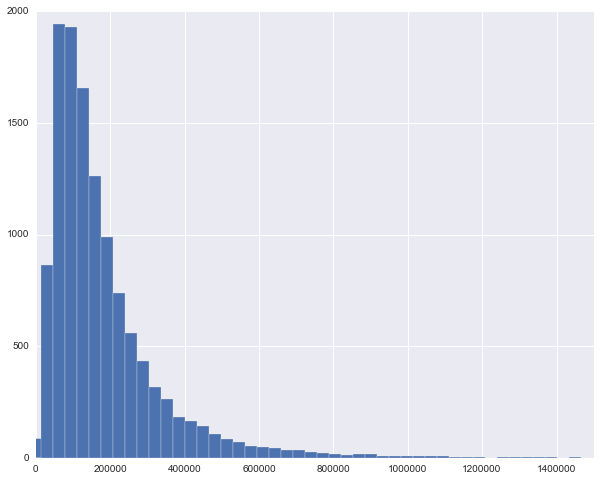

In [109]:
# the distribution of user_score for product_id = 1

a = df_con_1['user_score'].values.tolist()
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1)
ax.hist(a,bins = 1000)
ax.set_xlim([0,1500000])
plt.show()

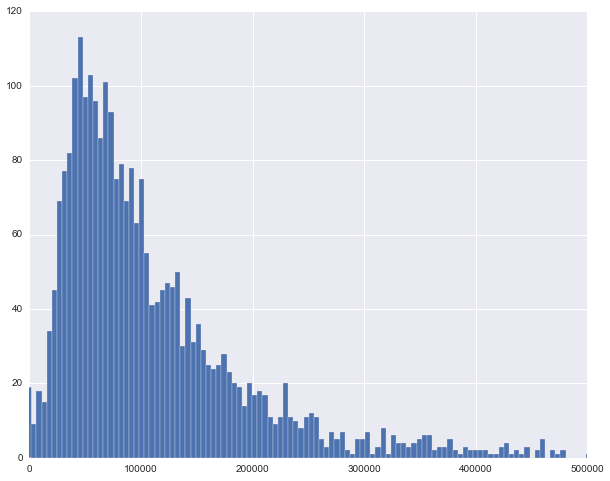

In [112]:
# the distribution of user_score for product_id = 2

a = df_con_2['user_score'].values.tolist()
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1)
ax.hist(a,bins = 500)
ax.set_xlim([0,500000])
plt.show()

After fixing missing values, check the current dataset : OK!

In [113]:
df_training = pd.read_table('/Users/Jem/Desktop/Rong360data/data/train.txt', sep = ',')
df_test = pd.read_table('/Users/Jem/Desktop/Rong360data/data/test.txt', sep = ',')

df_re1_ = pd.read_csv('/Users/Jem/Desktop/Rong360data/df_re_1.csv')
df_user_ = pd.read_csv('/Users/Jem/Desktop/Rong360data/user_clean.csv')
df_con_ = pd.read_csv('/Users/Jem/Desktop/Rong360data/df_con_(nomissing).csv')

In [114]:
data_user = pd.merge(df_user_, df_con_, on = 'user_id', how = 'outer')
data_tmp = pd.merge(df_re1_, data_user, on = 'user_id', how = 'outer')
data_training = pd.merge(df_training, data_tmp, on = 'user_id', how = 'left')
data_test = pd.merge(df_test, data_tmp, on = 'user_id', how = 'left')

In [119]:
d = data_training[data_training['product_id'] == 1]
d.isnull().sum(axis = 0)

user_id                           0
lable                             0
num_rel                         723
age                               0
sex                               0
expect_quota                      0
max_month_repay               21384
occupation                        0
education                         0
marital_status                    0
live_info                         0
local_hk                          0
money_function                    0
company_type                      1
salary                            1
school_type                       0
flow                              0
gross_profit                      0
business_type                     0
business_year                     1
personnel_num                     0
pay_type                          5
product_id                        0
tm_encode                         0
nrows_unique                      0
nrows                             0
cost_cnt                       8130
credit_lmt_amt              

In [120]:
len(d)

21384

# About product_id = 1 and product_id = 2, Find out where missing values come from in product_id = 1, 2

In [393]:
# product_id = 1, 2 will be different
# For product_id = 1, most missing values come from relation 2 (num_1,2,3, weight_1,2,3), and consumption
# For product_id = 2, most missing values come from relation 2 (num_1,2,3, weight_1,2,3), and consumption, user_info

d1 = data_training[data_training['product_id'] == 1]
d1.isnull().sum(axis = 0)

d2 = data_training[data_training['product_id'] == 2]
d2.isnull().sum(axis = 0)

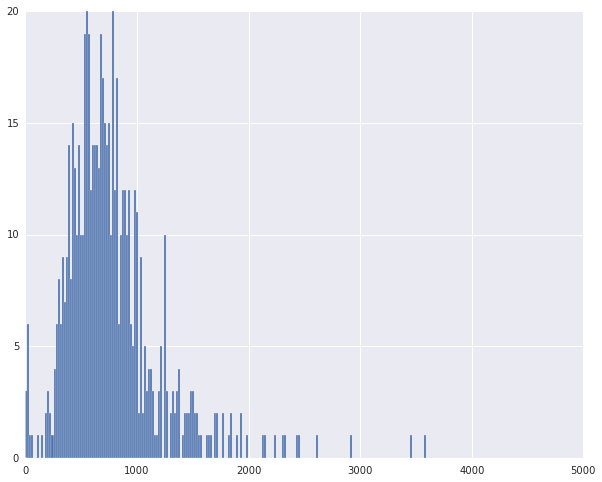

In [495]:
# be careful about the value of 18 in weight_3 (both d1 and d2)
# so wired about d1['weight_2']
# like a pulse for weight_1, Gaussian distribution for weight_2, weight_3

l = d2['weight_2'].dropna()
# l = l.replace(to_replace = np.nan, value = 0)
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(1,1,1)
list_ = l.values.tolist()
ax.hist(list_, bins = 200)
ax.set_xlim([0, 5000])
plt.show()

(0, 100)

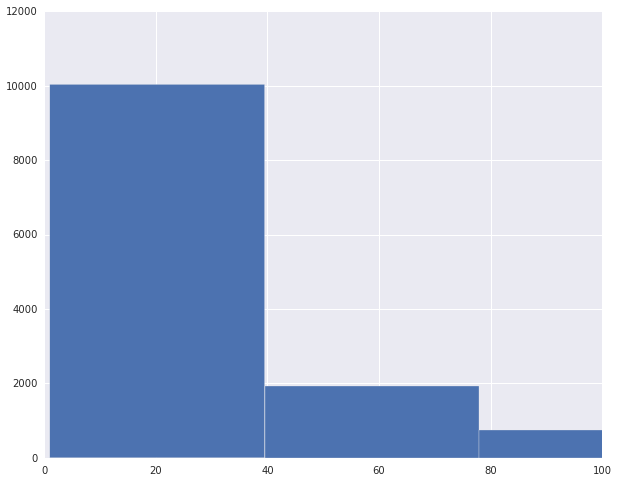

In [538]:
l = d1['total_num'].dropna()
# l = l.replace(to_replace = np.nan, value = 0)
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(1,1,1)
list_ = l.values.tolist()
ax.hist(list_, bins = 20)
ax.set_xlim([0, 100])

Conclusion: Introduce relation 2 will bring in so many missing values! For product_id = 2, some columns in user_info must be dropped since all values are missing!

about user1_id, user2_id in relation 1 (original data set): from this we know that drop user2_id in relation1 is 
reasonable. Also we know that relation 1 contributes a lot to both product_id

In [362]:
# for product_id = 1, find out the contribution of two user_id in relation 1
# 20661/21384 users from user1_id, 5982/21384 users from user2_id
# only 53 users in user2_id but not in user1_id, 0.2%

user2 = np.unique(df_re1['user2_id'].values)
a = np.unique(data_training[data_training['product_id'] == 1]['user_id'].values)
user1 = np.unique(df_re1['user1_id'].values)

a_user1 = list((set(a).union(set(user1)))^(set(a)^set(user1)))
print len(a_user1), len(a)

a_user2 = list((set(a).union(set(user2)))^(set(a)^set(user2)))
print len(a_user2), len(a)

a_user1_user2 = list(set(a_user1).union(set(a_user2))^set(a_user1))
print len(a_user1_user2), len(a)

20661 21384
5982 21384
53 21384


In [363]:
# for product_id = 2, find out the contribution of two user_id in relation 1
# 2217/4616 users from user1_id, 717/4616 users from user2_id
# only 110 users in user2_id but not in user1_id, 2.38%

user2 = np.unique(df_re1['user2_id'].values)
a = np.unique(data_training[data_training['product_id'] == 2]['user_id'].values)
user1 = np.unique(df_re1['user1_id'].values)

a_user1 = list((set(a).union(set(user1)))^(set(a)^set(user1)))
print len(a_user1), len(a)

a_user2 = list((set(a).union(set(user2)))^(set(a)^set(user2)))
print len(a_user2), len(a)

a_user1_user2 = list(set(a_user1).union(set(a_user2))^set(a_user1))
print len(a_user1_user2), len(a)

2217 4616
717 4616
110 4616


about user1_id, user2_id in relation 2 (original data set): from this we know that drop user2_id in relation2 is 
reasonable.
Also, we know that relation 2 contributes little to both product_id

In [366]:
# for product_id = 1, find out the contribution of two user_id in relation 2
# 6837/21384 users from user1_id, 767/21384 users from user2_id
# only 169 users in user2_id but not in user1_id, 0.79%

user2 = np.unique(df_re2['user2_id'].values)
a = np.unique(data_training[data_training['product_id'] == 1]['user_id'].values)
user1 = np.unique(df_re2['user1_id'].values)

a_user1 = list((set(a).union(set(user1)))^(set(a)^set(user1)))
print len(a_user1), len(a)

a_user2 = list((set(a).union(set(user2)))^(set(a)^set(user2)))
print len(a_user2), len(a)

a_user1_user2 = list(set(a_user1).union(set(a_user2))^set(a_user1))
print len(a_user1_user2), len(a)

6837 21384
767 21384
169 21384


In [367]:
# for product_id = 2, find out the contribution of two user_id in relation 2
# 639/4616 users from user1_id, 110/4616 users from user2_id
# only 24 users in user2_id but not in user1_id, 0.51%

user2 = np.unique(df_re2['user2_id'].values)
a = np.unique(data_training[data_training['product_id'] == 2]['user_id'].values)
user1 = np.unique(df_re2['user1_id'].values)

a_user1 = list((set(a).union(set(user1)))^(set(a)^set(user1)))
print len(a_user1), len(a)

a_user2 = list((set(a).union(set(user2)))^(set(a)^set(user2)))
print len(a_user2), len(a)

a_user1_user2 = list(set(a_user1).union(set(a_user2))^set(a_user1))
print len(a_user1_user2), len(a)

639 4616
110 4616
24 4616


Conclusion: we keep user1_id in both relation and drop user2_id.
For user1_id in relation 1, 20661/21384 for product_id = 1, 2217/4616 for product_id = 2
For user1_id in relation 2, 6837/21384 for product_id = 1, 639/4616 for product_id = 2

# Correlation matrix

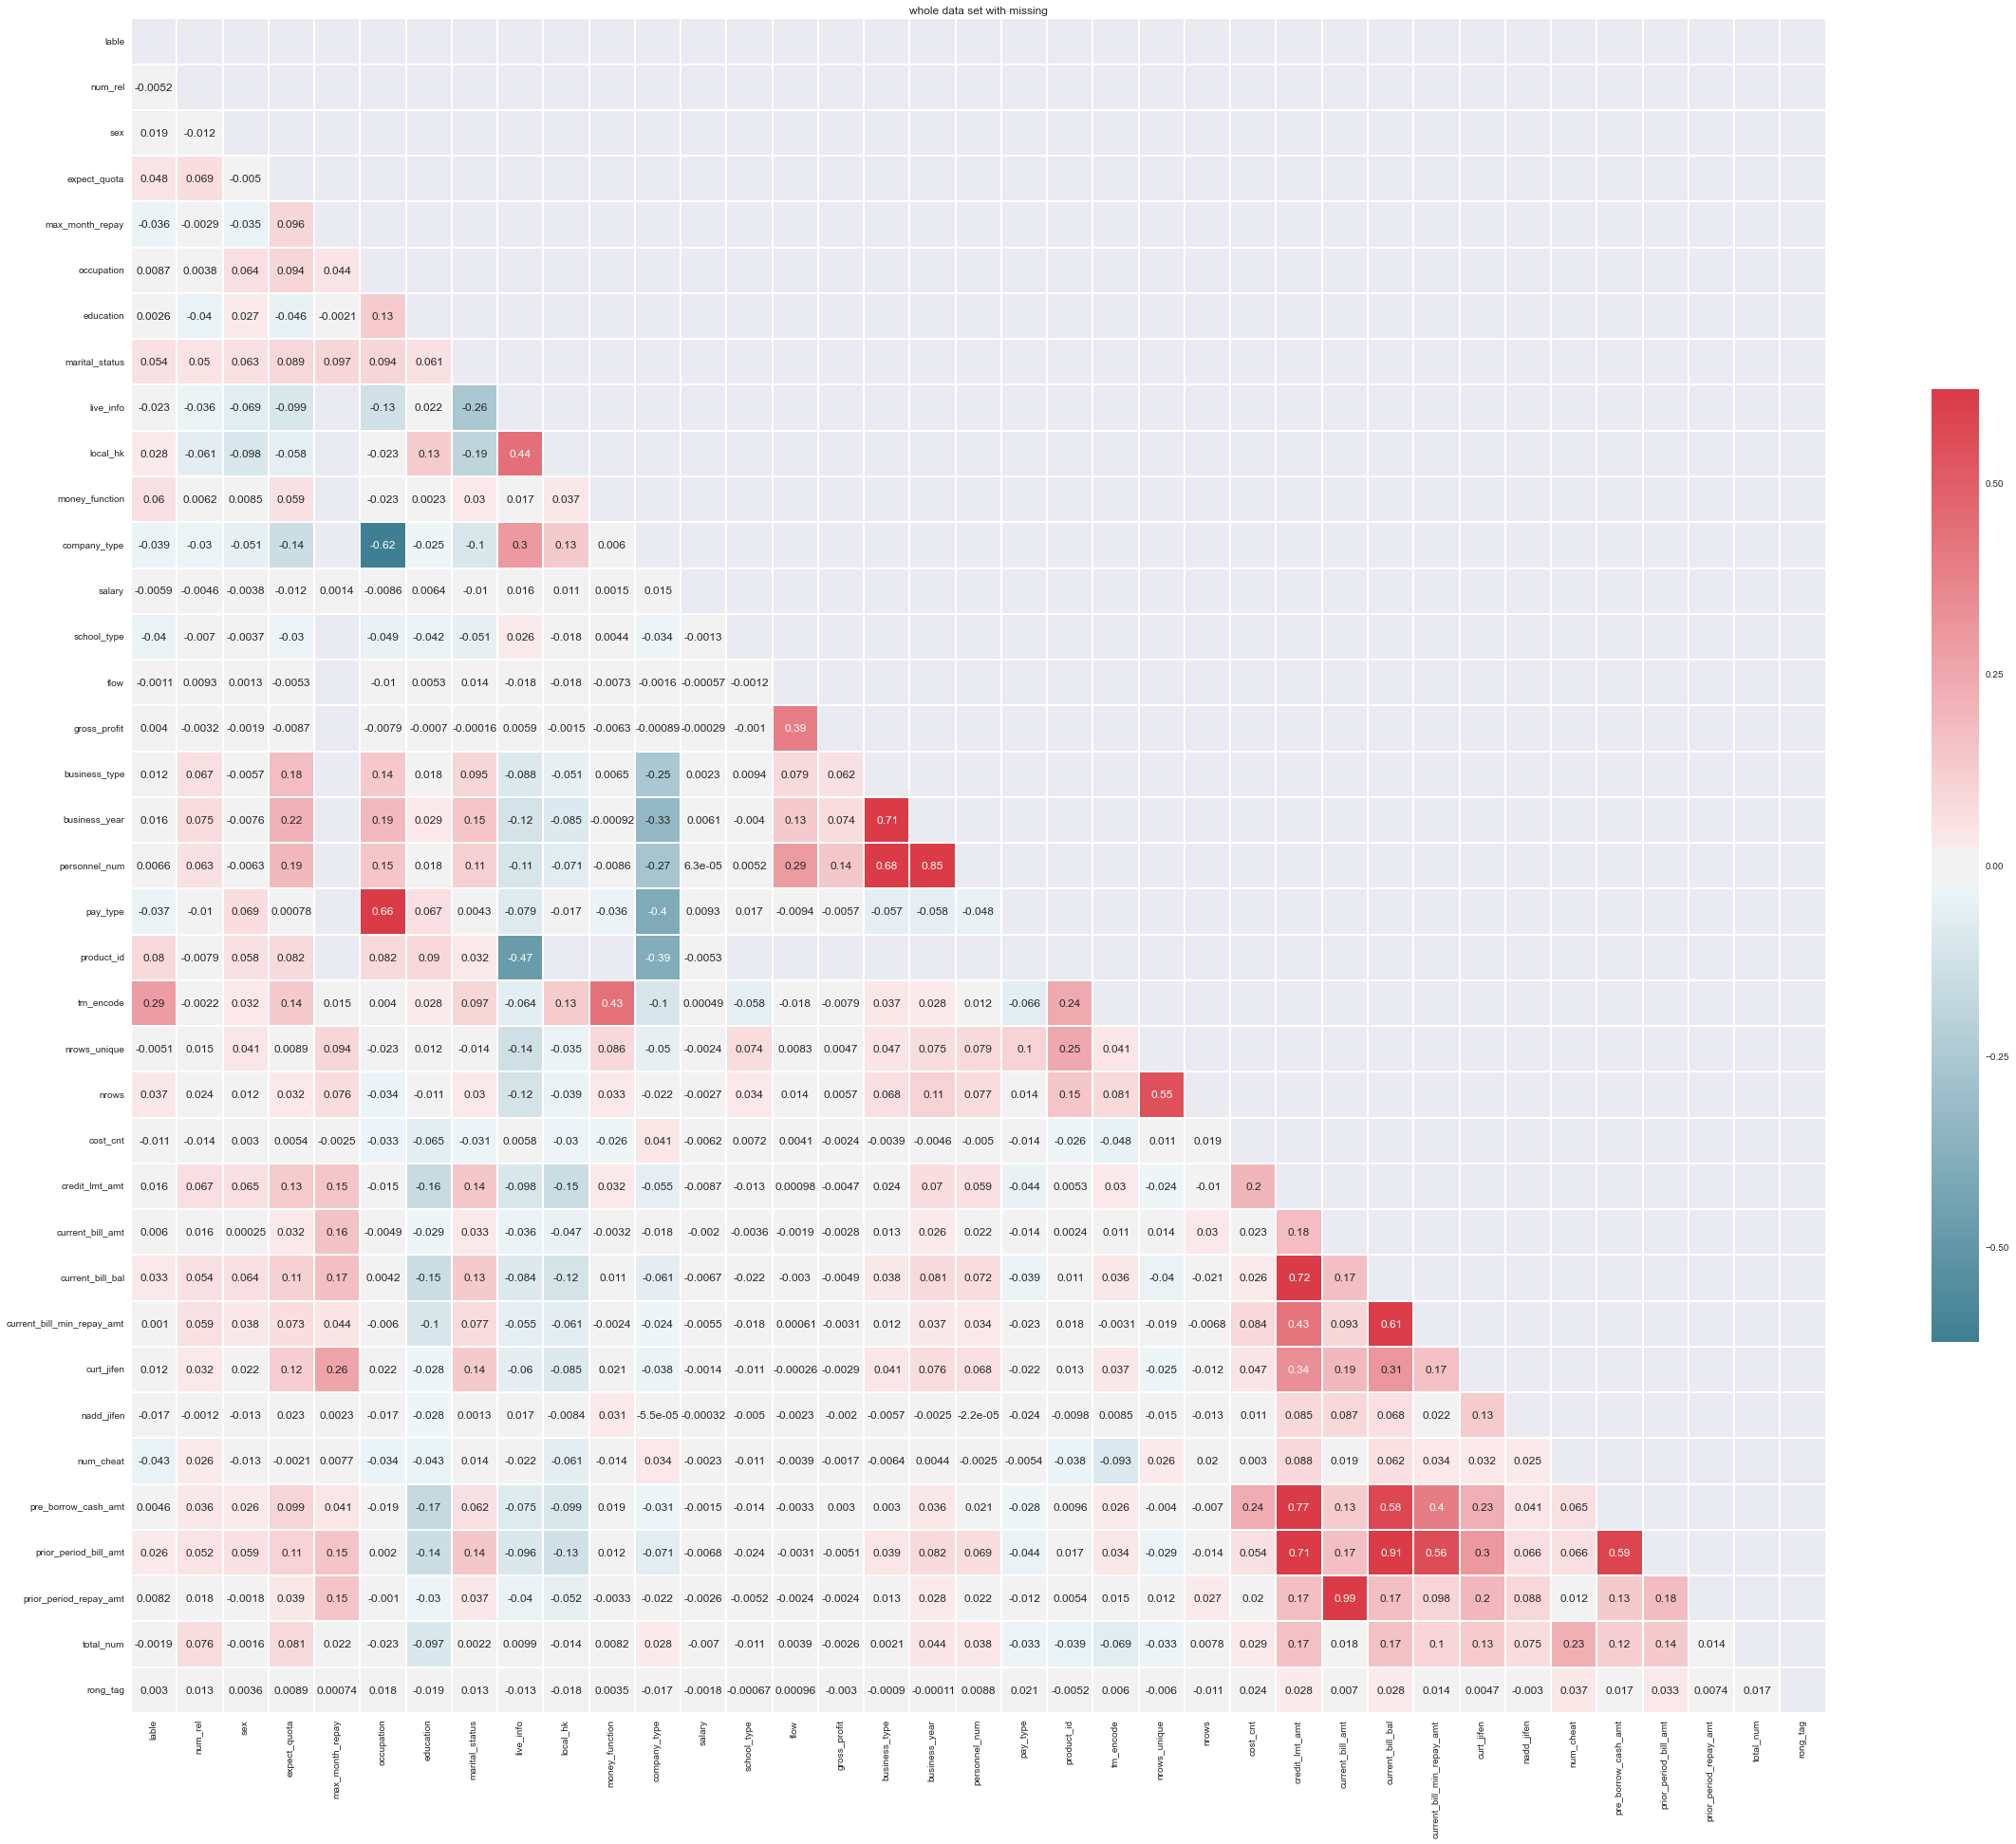

In [70]:
corr = data_training_rong.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(40, 36))
ax.set_title('whole data set with missing')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot = True)

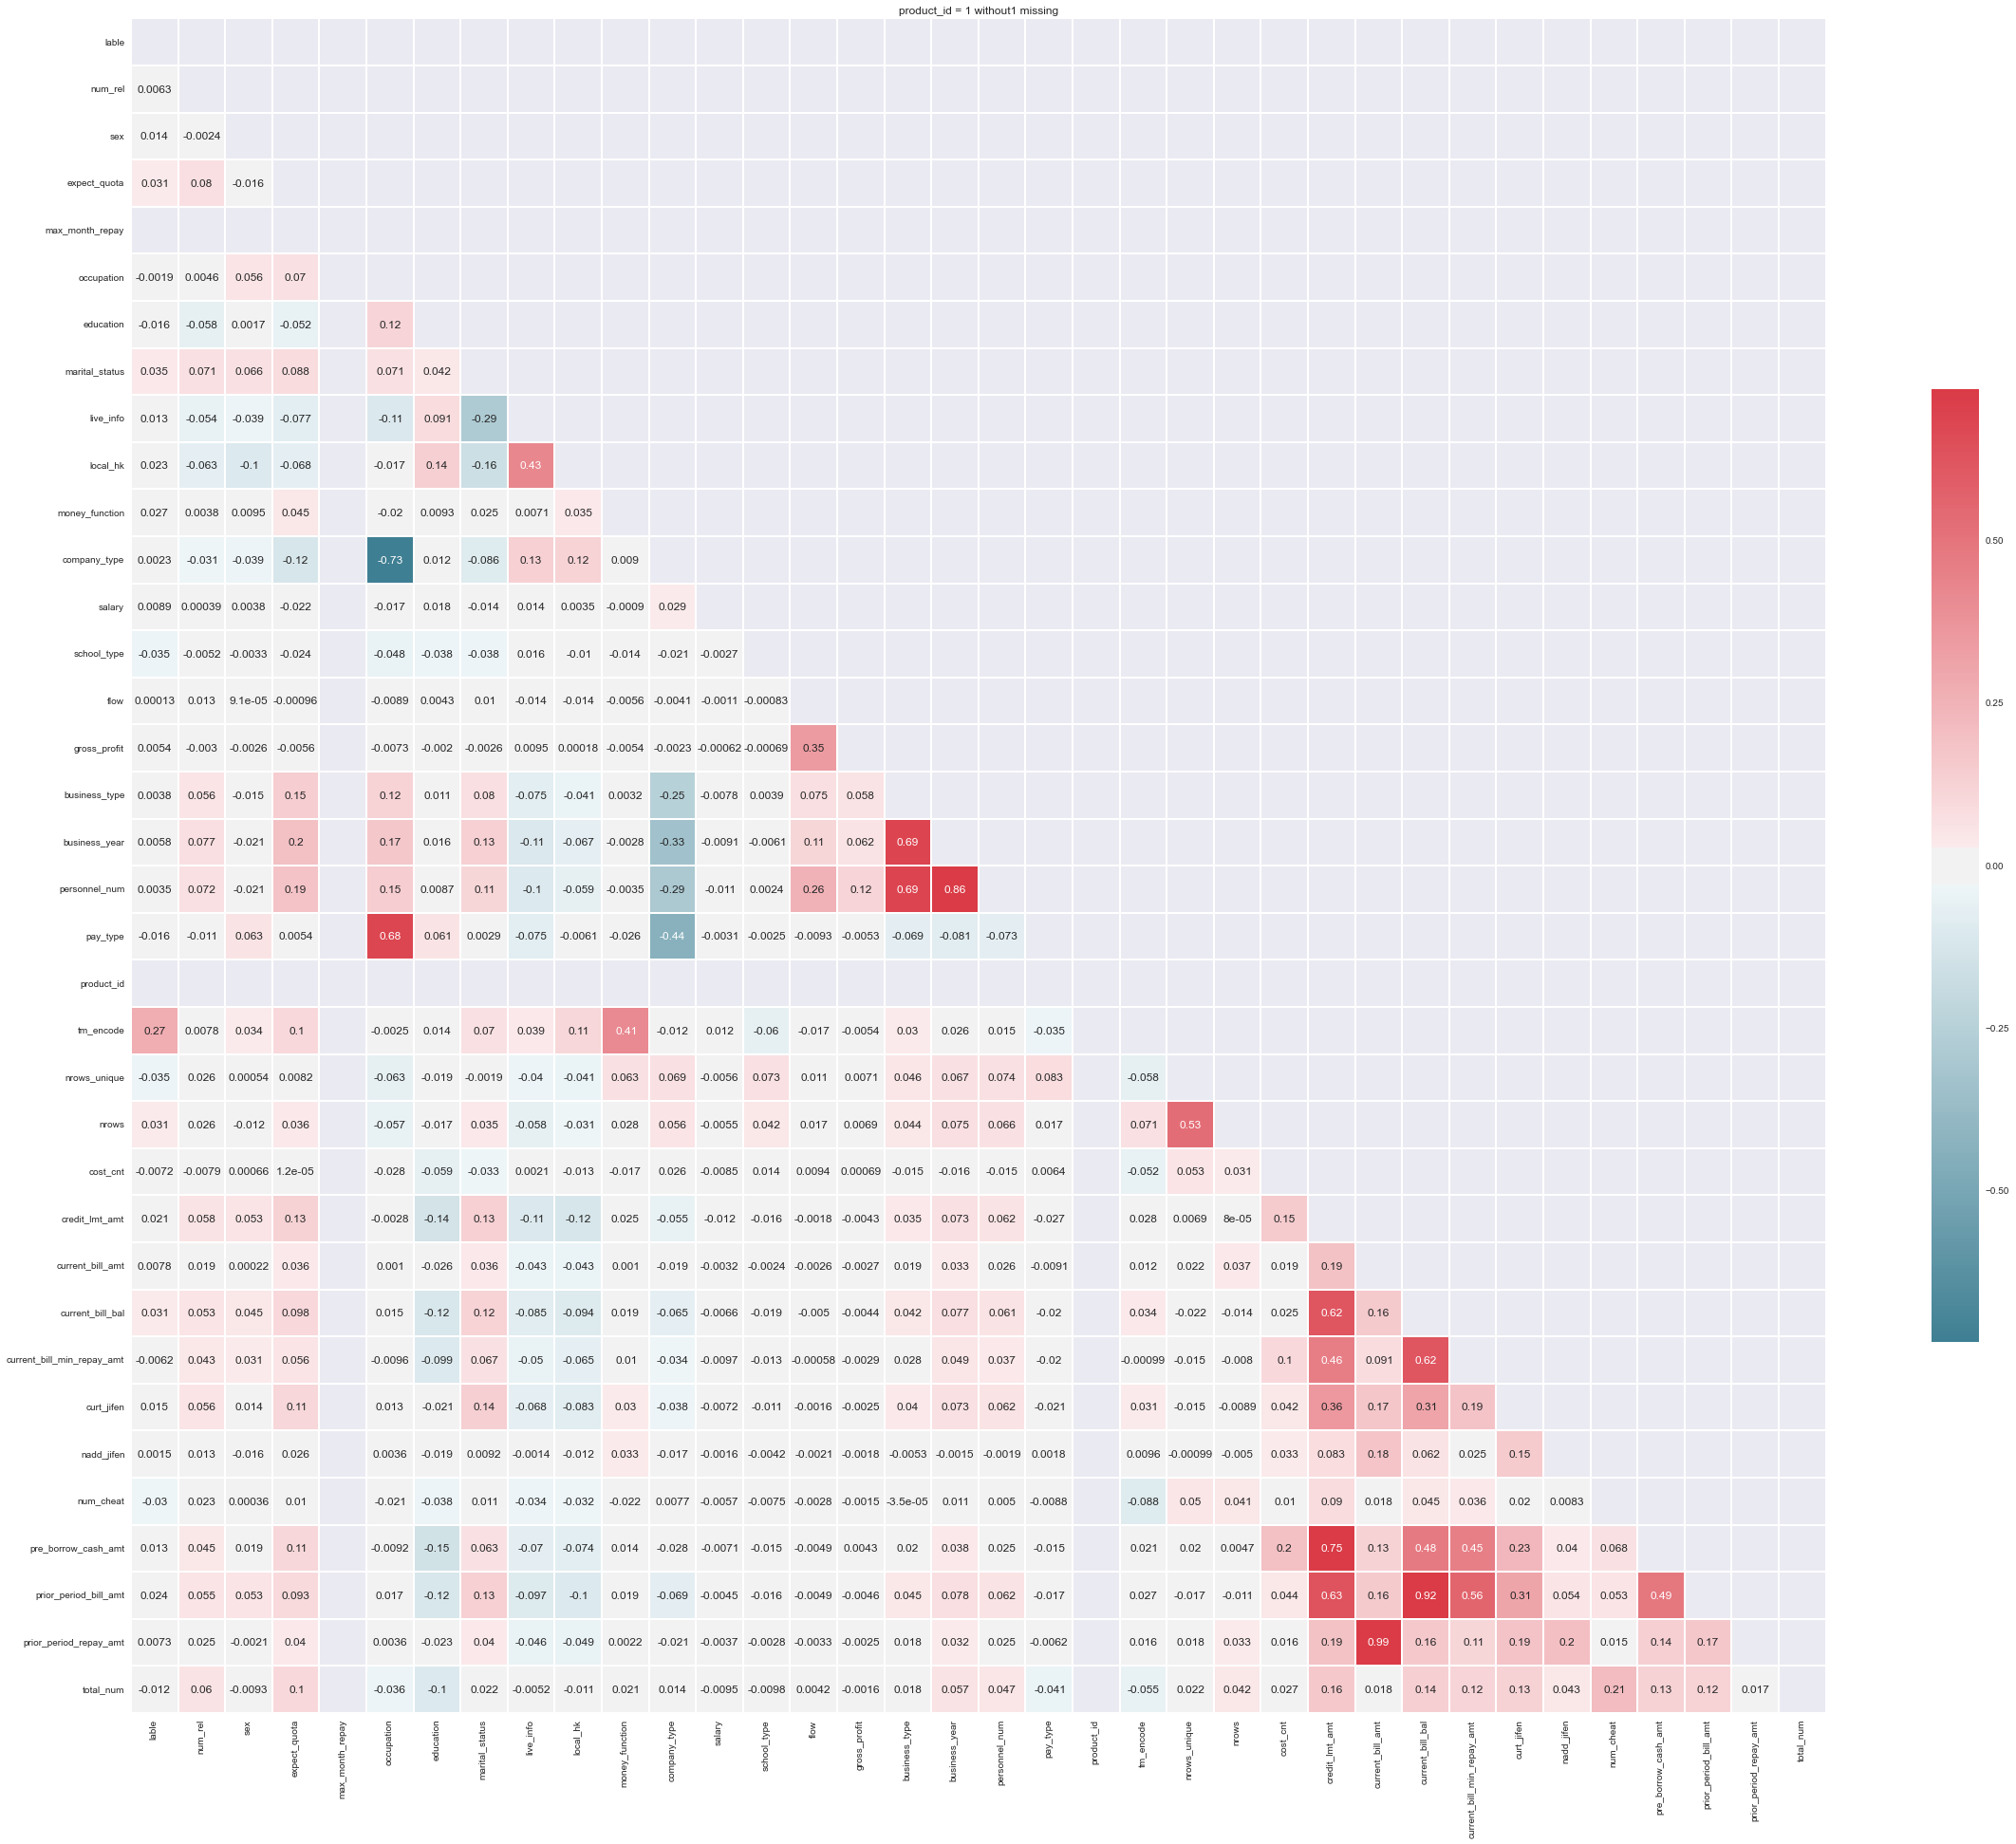

In [93]:
data_training_1 = data_training[data_training['product_id'] == 1]
# drop_list_1 = ['max_month_repay']
# data_training_1_rong = data_training_1_rong.drop(drop_list_1, axis = 1).dropna()

corr = data_training_1.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(40, 36))
ax.set_title('product_id = 1 without1 missing')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot = True)

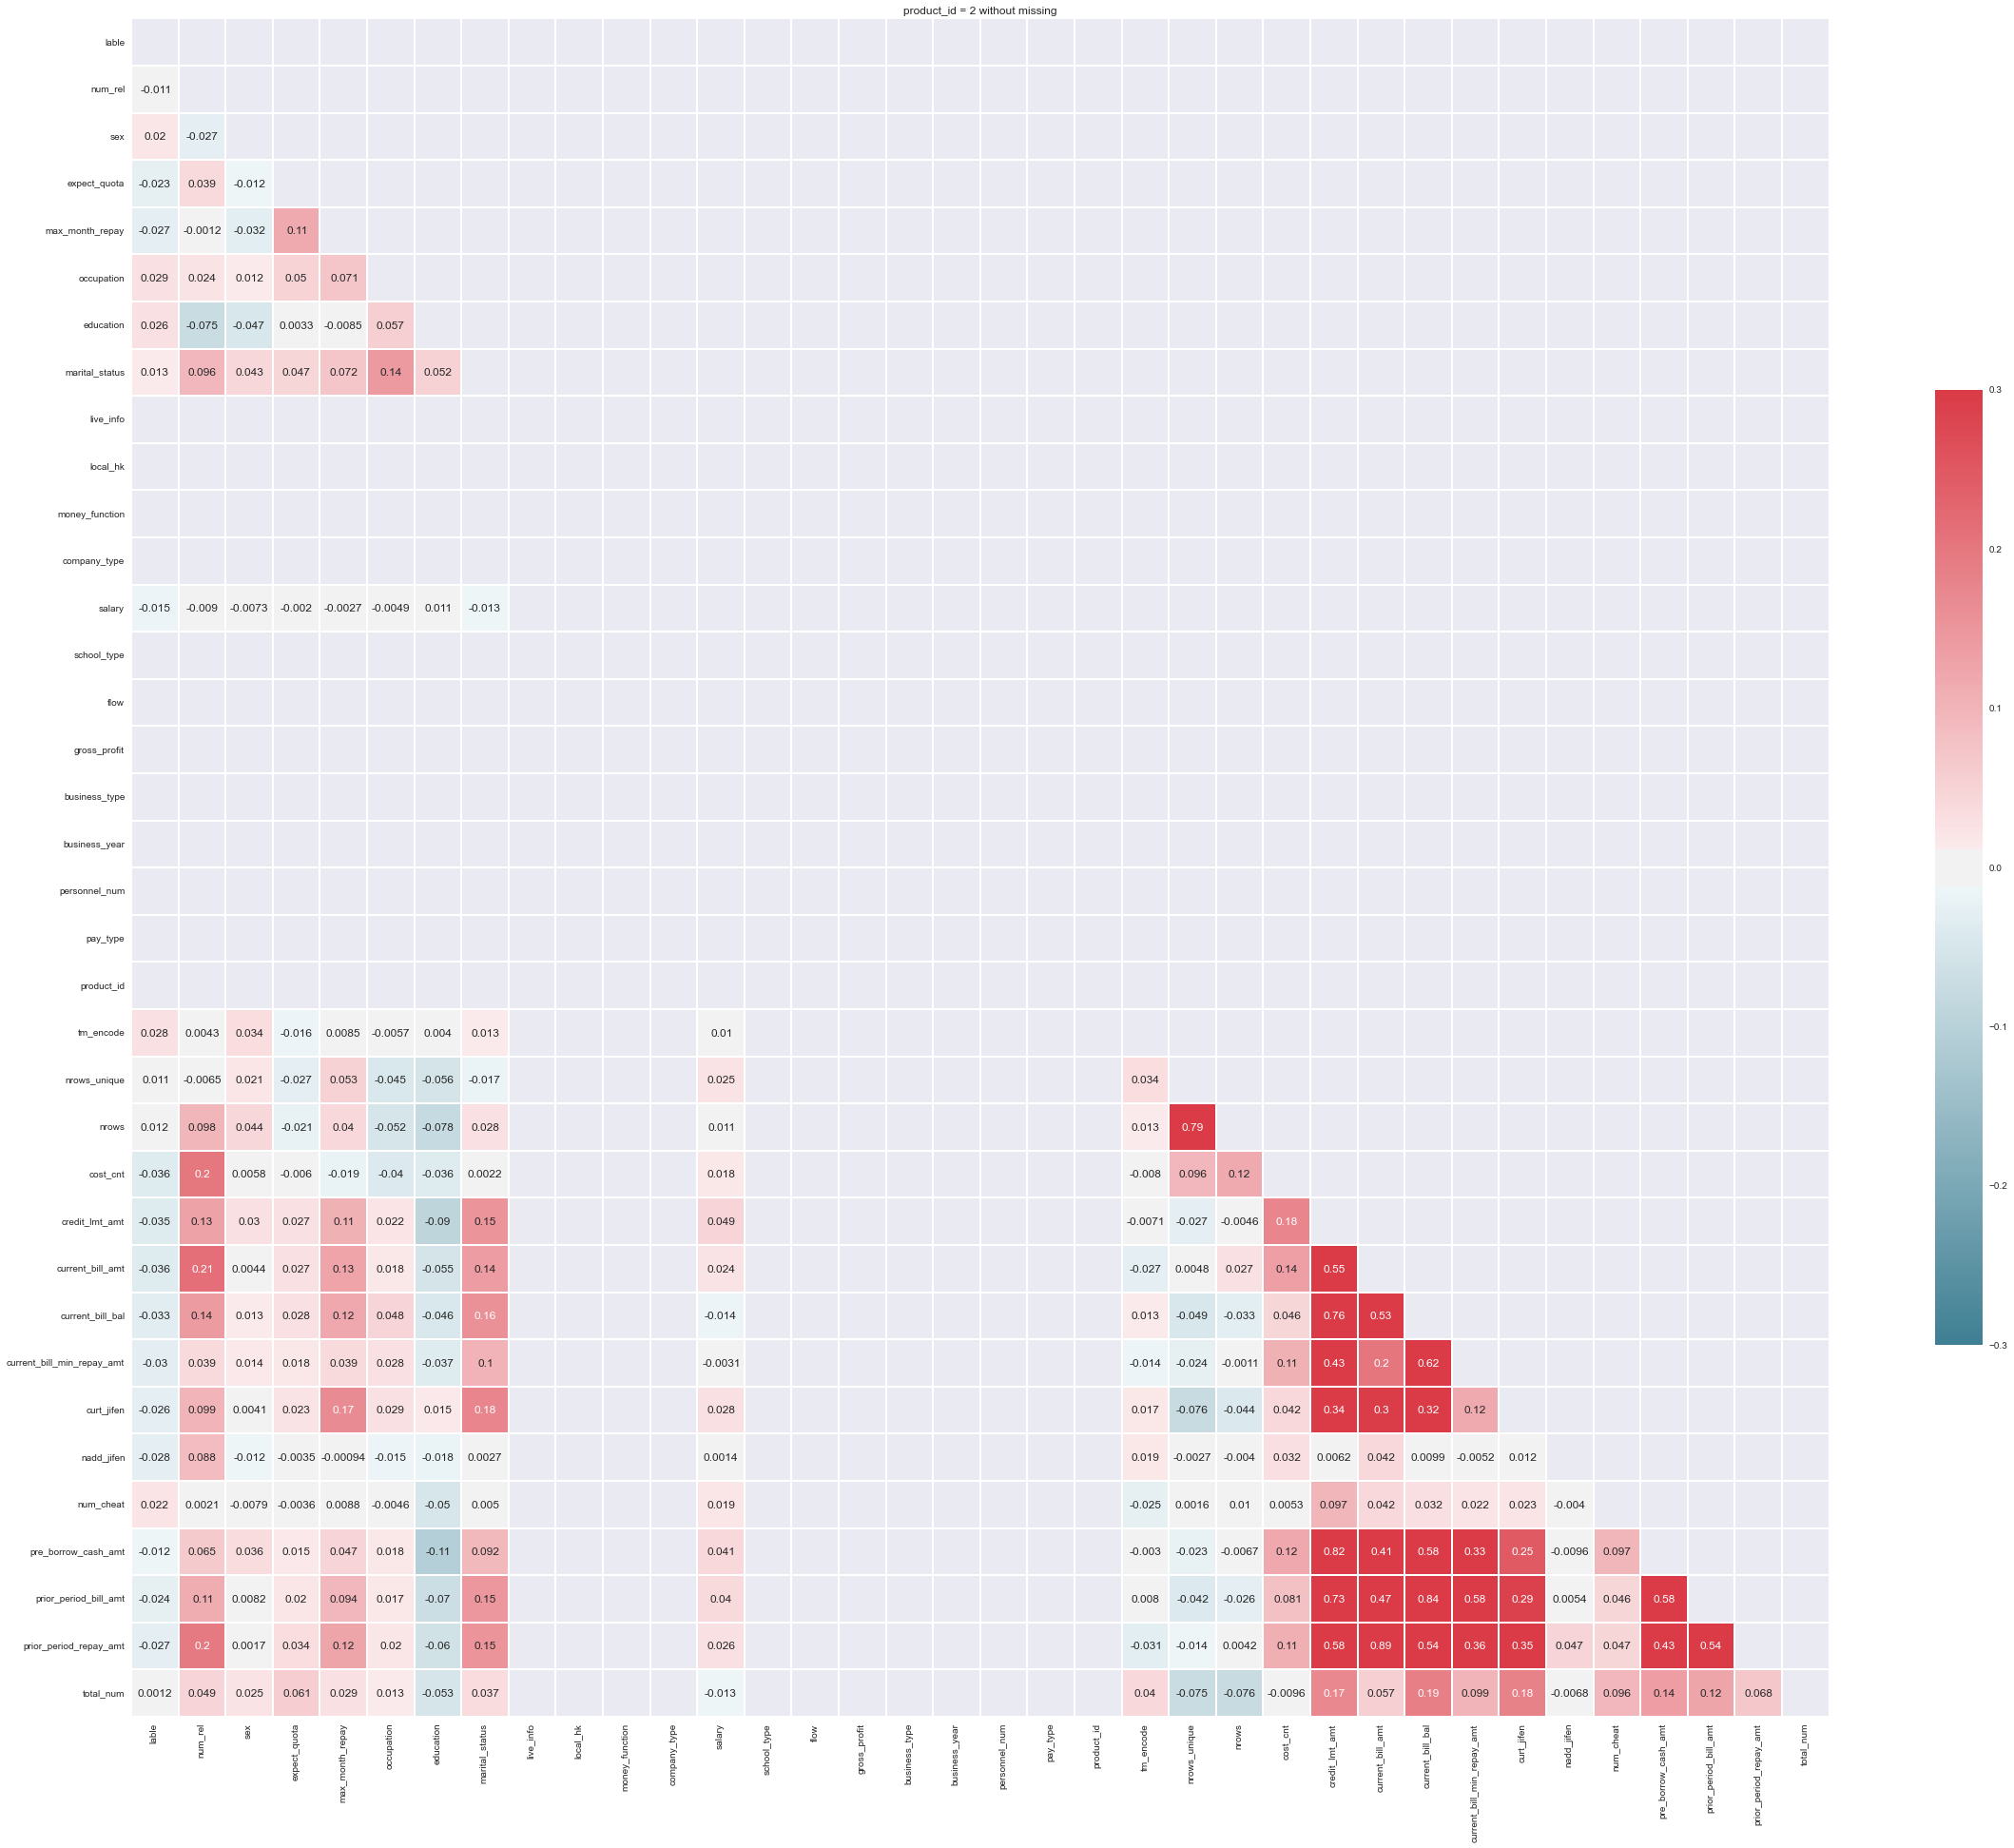

In [94]:
data_training_2 = data_training[data_training['product_id'] == 2]
# drop_list_2 = ['school_type', 'flow', 'gross_profit', 'business_type', 'business_year', 'personnel_num',
#               'pay_type', 'money_function', 'local_hk']
# data_training_2_rong = data_training_2_rong.drop(drop_list_2, axis = 1).dropna()

corr = data_training_2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(40, 36))
ax.set_title('product_id = 2 without missing')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True)

# Train test split

In [546]:
data_training.columns

Index([u'user_id', u'lable', u'num_rel', u'num_1', u'num_2', u'num_3',
       u'weight_1', u'weight_2', u'weight_3', u'age', u'sex', u'expect_quota',
       u'max_month_repay', u'occupation', u'education', u'marital_status',
       u'live_info', u'local_hk', u'money_function', u'company_type',
       u'salary', u'school_type', u'flow', u'gross_profit', u'business_type',
       u'business_year', u'personnel_num', u'pay_type', u'product_id',
       u'tm_encode', u'nrows_unique', u'nrows', u'cost_cnt', u'credit_lmt_amt',
       u'current_bill_amt', u'current_bill_bal', u'current_bill_min_repay_amt',
       u'curt_jifen', u'nadd_jifen', u'num_cheat', u'pre_borrow_cash_amt',
       u'prior_period_bill_amt', u'prior_period_repay_amt', u'total_num'],
      dtype='object')

In [594]:
from sklearn import cross_validation

data_training.replace(to_replace = 'NONE', value = np.nan, inplace = True, regex = True)
data_test.replace(to_replace = 'NONE', value = np.nan, inplace = True, regex = True)

test_data = data_test.drop(['user_id'], axis = 1)

train_y = data_training['lable']
train_x = data_training.drop(['lable', 'user_id'], axis = 1)

x_train, x_valid, y_train, y_valid = cross_validation.train_test_split(train_x,train_y,
                                                    test_size=0.33, random_state = 1234)

# Random Forest

In [596]:
from sklearn.ensemble import RandomForestClassifier


rf_tree = RandomForestClassifier(criterion = 'gini'
                                 , n_estimators = 5000
                                 , max_features = 0.7
                                 , max_depth = 6
                                 , min_samples_leaf = 1
                                 , min_samples_split = 1 
                                 , random_state = 1234)
rf_tree.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=0.7, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=1,
            min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=1,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

In [599]:
y_predict = rf_tree.predict_proba(test_data)